# 9. Analysis
After the bombardment, two kinds of analysis (mass loss and small molecules) are given as an example. Additional analysis like linear mass density, linear number density, linear temperature and spatial temperature can be seen in "lammps_tools.py".

## 9.1. Copy files

In [2]:
from pathlib import Path
from shutil import copy
cwd = Path.cwd()

source = cwd.parent/'8. Deposit'
copy(source/'data.lmp', cwd)
copy(source/'dump.lmp', cwd)

source = cwd.parent/'6. NVT'
copy(source/'ffield.reax.cho', cwd)

'c:\\Users\\fitbe\\Desktop\\AO Tutorial\\LAMMPS\\9. Analysis\\ffield.reax.cho'

## 9.2. Input file
The idea is to run `read_dump` for each frame and output the quantity we are interested in. Be careful, we change from `units metal` to `units real` by switching from AIREBO to ReaxFF. Make sure you understand the units for the quantity. For example, temperature and kinetic energy are clearly not correct in this case because the velocity units changed from Å/ps to Å/fs.

In [5]:
%%writefile in.lmp
#-------------------- Initilization ---------------#
units real
boundary p p fm
atom_style charge

#-------------------- Structure -------------------#
read_data data.lmp
variable zhi equal zhi
variable zhi0 equal ${zhi}
delete_atoms group all
variable nstep equal ${n}*${dump}/${dt}
read_dump ${dumpfile} ${nstep} x y z vx vy vz add yes box yes

#-------------------- Force Field -------------------#
pair_style reaxff NULL checkqeq no
pair_coeff * * ffield.reax.cho C H C H

#-------------------- Simulation -------------------#
reset_timestep ${nstep}

# AO
group PE type 1 2
group AO type 3

# Group
variable slab_zhi equal ${zhi0}+${slab_above}
region rslab block EDGE EDGE EDGE EDGE EDGE ${slab_zhi}
group slab region rslab
group Kslab intersect PE slab
group AOslab intersect AO slab
variable Mass equal mass(all)
variable mass equal mass(slab)
variable Kmass equal mass(Kslab)
variable AOslab equal count(AOslab)
group vacuum subtract all slab

# Compute
compute temp slab temp
compute Ktemp Kslab temp
compute pe_atom all pe/atom
compute pe slab reduce sum c_pe_atom
compute Kpe Kslab reduce sum c_pe_atom
compute ke all ke/atom
compute max_ke slab reduce max c_ke

fix spe1 all reaxff/species 1 1 1 all.spe element C H C H
fix spe2 vacuum reaxff/species 1 1 1 vacuum.spe element C H C H

thermo 1
thermo_style custom step temp c_temp c_Ktemp v_Mass v_mass v_Kmass v_AOslab pe c_pe c_max_ke

run 1

Overwriting in.lmp


Import packages

In [6]:
import subprocess 
import shlex

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lammps.formats as lmpf
import ovito.io as io

import re

Define a function that reads "dump.lmp", and run "in.lmp" to read dump frames and output a DataFrame.

In [7]:
def ReadDump(filename: str = 'dump.lmp', dump = 0.1, step: int = 1, slab_above: float = 0, num_frames: int = None, frames: list = None, dt: float = 0.0001, AO: bool = True, spe: bool = True):
    """
    Read dump file for thermo and write species file

    Parameters
        `filename` (str): dump file name
        
        `dump` (float): dump interval (ps)

        `step` (int): step size for reading dump file
        
        `slab_above` (float): slab distance above the surface (Å)

        `num_frames` (int): number of frames to read

        `frames` (list): list of frames to read
        
        `dt` (float): time step (ps)
        
        `AO` (bool): whether to include No. of AO in the log file

    Returns
        `log` (DataFrame): log thermo output
    """
    pipeline = io.import_file(filename)
    if num_frames is None:
        num_frames = pipeline.source.num_frames
    
    if (num_frames-1) % step != 0:
        print(f'Warning: {num_frames-1} frames are not divisible by {step}')
        return
    if frames is None:
        index = np.arange(0, num_frames, step)
    else:
        index = np.array(frames)

    end = max(index)
    # create an empty numpy array
    dict = {}

    if spe:
        f1 = open('all.all.spe', 'w')
        f11 = open('vacuum.all.spe', 'w')
    
    for i in index:
        # Run 'in.lmp'
        command_line = f'lmp -in in.lmp -var dump {dump} -var n {i} -var num {end-i} -var dumpfile {filename} -var slab_above {slab_above} -var dt {dt} -log log.lmp'
        args = shlex.split(command_line)
        p = subprocess.Popen(args)
        p.wait()

        # Read 'log.lmp'
        file = lmpf.LogFile('log.lmp')
        Log = file.runs[0]
        for key in Log.keys():
            if key not in dict:
                dict[key] = []
            dict[key].append(Log[key][0])
        
        # Read 'all.spe'
        # Write 'all.all.spe'
        try:
            with open('all.spe') as f2:
                lines = f2.readlines()
            for line in lines:
                if 'Timestep' in line:
                    pass
                else:
                    temp = line.split()
                    old = temp[0]
                    new = str(int(old) - 1)
                    temp[0] = new
                    line = '\t'.join(temp)
                f1.write(line)
            f1.write('\n')
        except FileNotFoundError:
            pass
        
        # Read 'vaccuum.spe'
        # Write 'vacuum.all.spe'
        try:
            with open('vacuum.spe') as f22:
                lines = f22.readlines()
            for line in lines:
                if 'Timestep' in line:
                    pass
                else:
                    temp = line.split()
                    old = temp[0]
                    new = str(int(old) - 1)
                    temp[0] = new
                    line = '\t'.join(temp)
                f11.write(line)
            f11.write('\n')
        except FileNotFoundError:
            pass
    
    if spe:
        f1.close()
        f11.close()

    log = pd.DataFrame(dict) 
    log['Time'] = log['Step'] * dt   # ps
    log = log[['Time'] + [col for col in log.columns if col != 'Time']]
    log = log[['Step'] + [col for col in log.columns if col != 'Step']]
    
    if AO:
        log['AO'] = log.index
    log.to_csv('log.csv', index=False)

In [8]:
ReadDump(dump=0.1, slab_above=0, dt=0.0001)

In [9]:
log = pd.read_csv('log.csv')
log

Step  Time         Temp       c_temp      c_Ktemp     v_Mass  \
0       0.0   0.0  293808400.0  293808400.0  293808400.0  8476.4244   
1    1000.0   0.1  320853830.0  306842500.0  306842500.0  8488.4351   
2    2000.0   0.2  324188170.0  296145380.0  296145380.0  8500.4458   
3    3000.0   0.3  332454110.0  304453050.0  302541750.0  8512.4565   
4    4000.0   0.4  345579970.0  317603420.0  305165350.0  8524.4672   
5    5000.0   0.5  353826640.0  325855710.0  309304690.0  8536.4779   
6    6000.0   0.6  360286150.0  330916460.0  323869460.0  8548.4886   
7    7000.0   0.7  364737250.0  335913390.0  325227490.0  8560.4993   
8    8000.0   0.8  374353500.0  345093780.0  334029380.0  8572.5100   
9    9000.0   0.9  386563630.0  357326540.0  341628110.0  8584.5207   
10  10000.0   1.0  391895050.0  362695800.0  345374400.0  8596.5314   
11  11000.0   1.1  388970420.0  359791960.0  352270070.0  8608.5421   
12  12000.0   1.2  414271980.0  380341430.0  363993670.0  8620.5528   
13  13000.0   1.3  413740300.0  379850330.0  364167160.0  8632.5635   
14  14000.0   1.4  421181470.0  387317840.0  370483100.0  8644.5742   
15  15000.0   1.5  426609810.0  392731530.0  370450110.0  8656.5849   
16  16000.0   1.6  432884660.0  393581730.0  383842090.0  8668.5956   
17  17000.0   1.7  442339110.0  403150970.0  390609180.0  8680.6063   
18  18000.0   1.8  445167270.0  406017550.0  391746970.0  8692.6170   
19  19000.0   1.9  464375590.0  425340110.0  402261290.0  8704.6277   
20  20000.0   2.0  459298610.0  414117700.0  397284370.0  8716.6384   
21  21000.0   2.1  469402430.0  424309120.0  415188100.0  8728.6491   
22  22000.0   2.2  477985340.0  432850470.0  416914210.0  8740.6598   
23  23000.0   2.3  487520090.0  442432150.0  419064200.0  8752.6705   
24  24000.0   2.4  499260640.0  455708220.0  425581390.0  8764.6812   
25  25000.0   2.5  490785690.0  445633760.0  425390890.0  8776.6919   
26  26000.0   2.6  505060590.0  464560380.0  435706540.0  8788.7026   
27  27000.0   2.7  489057710.0  442070670.0  428613590.0  8800.7133   
28  28000.0   2.8  504006680.0  452446980.0  435878010.0  8812.7240   
29  29000.0   2.9  514222470.0  463022180.0  443439650.0  8824.7347   
30  30000.0   3.0  527806220.0  476602400.0  443422450.0  8836.7454   
31  31000.0   3.1  544620070.0  487107640.0  456881550.0  8848.7561   
32  32000.0   3.2  568281670.0  485041780.0  454001290.0  8860.7668   
33  33000.0   3.3  552450330.0  508935750.0  457426680.0  8872.7775   
34  34000.0   3.4  552207500.0  513532880.0  455703180.0  8884.7882   
35  35000.0   3.5  564830430.0  513372020.0  469644270.0  8896.7989   
36  36000.0   3.6  572571150.0  518790800.0  494084330.0  8908.8096   
37  37000.0   3.7  575153180.0  520202990.0  497694390.0  8920.8203   
38  38000.0   3.8  604443040.0  550362980.0  502846390.0  8932.8310   
39  39000.0   3.9  614399350.0  542344690.0  507479080.0  8944.8417   
40  40000.0   4.0  641588900.0  563770300.0  505903820.0  8956.8524   
41  41000.0   4.1  634800660.0  557632080.0  512018780.0  8968.8631   
42  42000.0   4.2  634332240.0  559103660.0  516142060.0  8980.8738   
43  43000.0   4.3  658343120.0  563653150.0  515831710.0  8992.8845   
44  44000.0   4.4  646267090.0  565267900.0  527800030.0  9004.8952   
45  45000.0   4.5  658861010.0  593499490.0  533071180.0  9016.9059   
46  46000.0   4.6  676326050.0  594608220.0  537584110.0  9028.9166   
47  47000.0   4.7  671064090.0  593052300.0  553542710.0  9040.9273   
48  48000.0   4.8  674072180.0  585495510.0  557425930.0  9052.9380   
49  49000.0   4.9  700345160.0  618156390.0  578508310.0  9064.9487   
50  50000.0   5.0  696753110.0  598853560.0  568491690.0  9076.9594   

       v_mass    v_Kmass  v_AOslab     PotEng       c_pe     c_max_ke  AO  
0   8476.4244  8476.4244       0.0 -199001.25 -199001.25    5991734.7   0  
1   8476.4244  8476.4244       0.0 -199062.20 -199059.71    4904165.2   1  
2   8474.4085  8474.4085       0.0 -199066.84 -198947.71    5399667.2   2  
3   8488.4

## 9.3. Mass loss and yield

<Axes: xlabel='No. of AO', ylabel='AO Absorbed'>

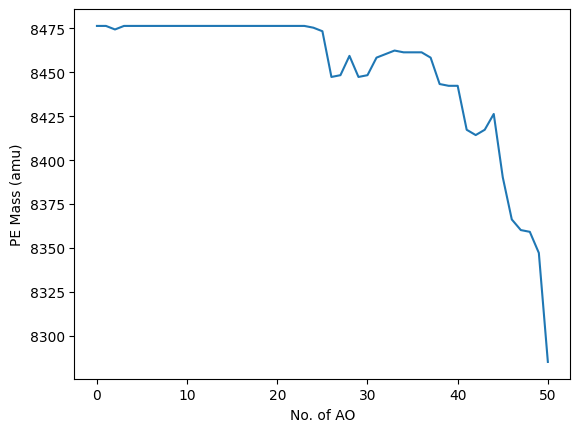

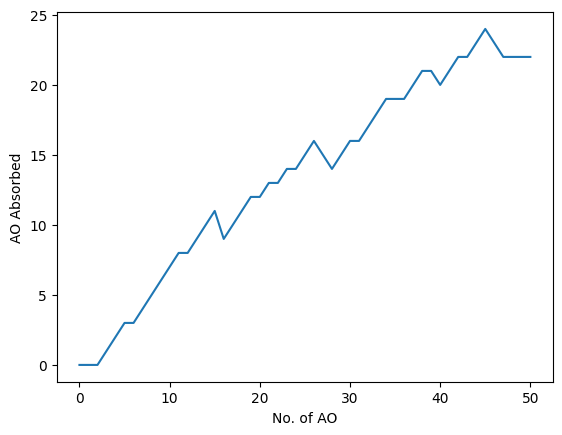

In [12]:
log.plot(x='AO', y=['v_Kmass'], xlabel='No. of AO', ylabel='PE Mass (amu)', legend=False)
log.plot(x='AO', y=['v_AOslab'], xlabel='No. of AO', ylabel='AO Absorbed', legend=False)

<Axes: xlabel='No. of AO', ylabel='Normalized Mass'>

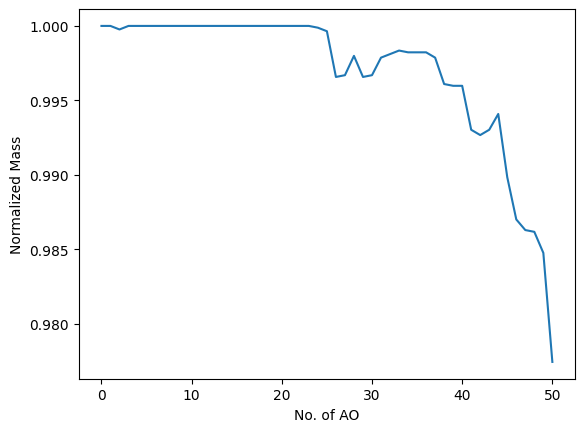

In [13]:
m0 = log['v_Kmass'][0]
log['mloss'] = m0 - log['v_Kmass']
log['norm_mass'] = log['v_Kmass'] / m0
log.plot(x='AO', y=['norm_mass'], xlabel='No. of AO', ylabel='Normalized Mass', legend=False)

Load the area of the 2D slab

In [19]:
pipeline = io.import_file(location='data.lmp', input_format='lammps/data', atom_style='charge')
data = pipeline.compute()
lx, ly = data.cell[0][0], data.cell[1][1]
area = lx*ly

In [20]:
AO = log.index.to_numpy()
log['fluence'] = log.index / area
AO[0] = 1

In [21]:
log['Kyield'] = log['mloss'] / AO * 1.66054    # 10^-24 g
log.plot(x='AO', y=['Kyield'], xlabel='No. of AO', ylabel='Yield (10^-24 g)', legend=False)

<Axes: xlabel='No. of AO', ylabel='Yield (10^-24 g)'>

## 9.4. Species
We are interested in the small molecules escaped from the surface.

In [22]:
species = ['C', 'CH', 'CH2', 'H', 'H2']

In [23]:
def SmallSpeFile(filename: str = 'species.lmp', dt: float = 0.0001, species: list = None, delete: bool = False, times: list = None):
    """
    Read Species file and return a pandas DataFrame

    Parameters
        `file` (str): Species filename

        `dt` (float): time step (ps)

        `species` (list): list of species to read
        
        `delete` (bool): whether atoms are deleted in the simulation

        `times` (list): list of times to read

    Returns
        `spe` (DataFrame): pandas DataFrame with species of interest
    """

    # Read the file
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Initialize an empty dictionary to store the data
    if species is None:
        species = ['CO', 'CO2', 'H', 'H2', 'H2O', 'O', 'O2']
    dict = {'Timestep': [], 'No_Moles': [], 'No_Specs': []}
    for spec in species:
        dict[spec] = []

    # Iterate through lines to find headers and data
    for line in lines:
        if line.startswith("#"):
            # This line contains headers
            headers = line.split()[1:]
            for key in dict.keys():
                if key not in headers:
                    dict[key].append(0)                
        else:
            # This line contains data
            values = line.split()
            for header, value in zip(headers, values):
                if header in dict:
                    dict[header].append(int(value))

    # Convert the dictionary to a pandas DataFrame
    spe = pd.DataFrame(dict)
    if times is not None:
        spe['Time'] = times
    else:
        spe['Time'] = spe['Timestep'] * dt   # ps
    spe = spe[['Time'] + [col for col in spe.columns if col != 'Time']]
    
    if delete:
        # For each row in the datafram spe, add all the previous rows up to the current row to give the cumulative sum
        # Except for Time, Timestep, and No_Specs columns
        # Use column name to determine
        for col in spe.columns:
            if col not in ['Time', 'Timestep', 'No_Specs']:
                spe[col] = spe[col].cumsum()
        # Update No_Specs column by determining the number of non-zero columns excluding Time, Timestep, and No_Moles, and No_Specs columns
        spe['No_Specs'] = spe.iloc[:, 4:].astype(bool).sum(axis=1)
        
    return spe

In [24]:
spe = SmallSpeFile(filename='vacuum.all.spe', dt=0.0001, species=species, times=None)
spe

Time  Timestep  No_Moles  No_Specs   C  CH  CH2  H  H2
0    0.0         0         0         0   0   0    0  0   0
1    0.1      1000         1         1   1   0    0  0   0
2    0.2      2000         4         2   2   0    0  2   0
3    0.3      3000         2         1   2   0    0  0   0
4    0.4      4000         2         1   2   0    0  0   0
5    0.5      5000         2         1   2   0    0  0   0
6    0.6      6000         3         1   3   0    0  0   0
7    0.7      7000         3         1   3   0    0  0   0
8    0.8      8000         3         1   3   0    0  0   0
9    0.9      9000         3         1   3   0    0  0   0
10   1.0     10000         3         1   3   0    0  0   0
11   1.1     11000         3         1   3   0    0  0   0
12   1.2     12000         4         1   4   0    0  0   0
13   1.3     13000         4         1   4   0    0  0   0
14   1.4     14000         4         1   4   0    0  0   0
15   1.5     15000         4         1   4   0    0  0   0
16   1.6     16000         7         1   7   0    0  0   0
17   1.7     17000         7         1   7   0    0  0   0
18   1.8     18000         7         1   7   0    0  0   0
19   1.9     19000         7         1   7   0    0  0   0
20   2.0     20000         8         1   8   0    0  0   0
21   2.1     21000         8         1   8   0    0  0   0
22   2.2     22000         9         1   9   0    0  0   0
23   2.3     23000         9         1   9   0    0  0   0
24   2.4     24000        11         2  10   0    0  1   0
25   2.5     25000        13         2  10   0    0  3   0
26   2.6     26000        12         3  10   0    0  1   0
27   2.7     27000        13         2  12   0    0  0   0
28   2.8     28000        17         3  14   0    0  2   0
29   2.9     29000        15         2  14   0    0  0   0
30   3.0     30000        15         2  14   0    0  0   0
31   3.1     31000        19         3  15   0    0  3   0
32   3.2     32000        17         4  13   0    1  2   0
33   3.3     33000        17         3  15   1    0  1   0
34   3.4     34000        17         3  15   0    1  1   0
35   3.5     35000        18         3  16   0    1  1   0
36   3.6     36000        19         3  17   0    1  1   0
37   3.7     37000        22         3  17   0    1  4   0
38   3.8     38000        23         4  17   0    1  4   0
39   3.9     39000        24         3  18   0    0  4   0
40   4.0     40000        26         3  20   0    0  4   0
41   4.1     41000        25         4  20   0    0  2   0
42   4.2     42000        27         4  20   0    0  4   0
43   4.3     43000        28         6  19   2    1  4   0
44   4.4     44000        31         5  19   0    1  9   0
45   4.5     45000        27         4  21   0    0  4   0
46   4.6     46000        27         5  23   0    1  1   0
47   4.7     47000        32         5  25   0    0  4   0
48   4.8     48000        34         4  26   0    0  6   0
49   4.9     49000        35         4  27   0    0  6   0
50   5.0     50000        31         4  28   0    1  0   0

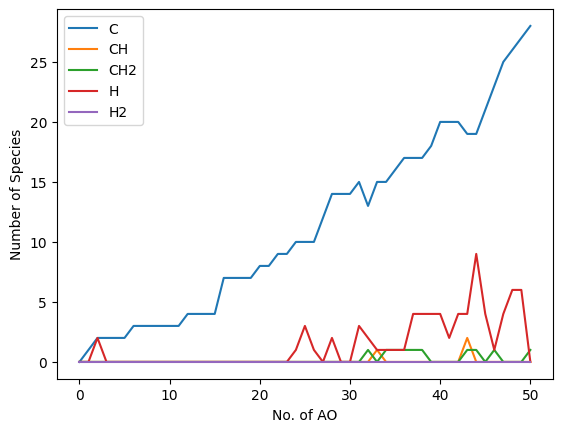

In [25]:
for i in species:
    plt.plot(spe.index, spe[i], label=i)
plt.xlabel('No. of AO')
plt.ylabel('Number of Species')
plt.legend()
plt.show()